In [ ]:
# Importing libraries
!pip install contractions
!pip install cleantext

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import contractions
import cleantext
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Get preprocessed dataset
!wget https://raw.githubusercontent.com/tasdikrahman/datasets/master/email/csv/spam-apache.csv

--2022-10-25 23:58:58--  https://raw.githubusercontent.com/tasdikrahman/datasets/master/email/csv/spam-apache.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366506 (358K) [text/plain]
Saving to: ‘spam-apache.csv.1’

spam-apache.csv.1   100%[===================>] 357.92K  --.-KB/s    in 0.03s   

2022-10-25 23:58:58 (10.0 MB/s) - ‘spam-apache.csv.1’ saved [366506/366506]



In [ ]:
# Read dataset and convert -1 and 1 to boolean
email_data = pd.read_csv("spam-apache.csv", header=None, names=['spam', 'text'])
email_data.spam = email_data.spam.apply(lambda s: True if s==-1 else False)
email_data.head()

,spam,text
0,True,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
1,False,> Russell Turpin:\n> > That depends on how the...
2,True,Help wanted. We are a 14 year old fortune 500...
3,True,Request A Free No Obligation Consultation!\nAc...
4,False,Is there a way to look for a particular file o...


In [ ]:
# How many samples in dataframe of spam or ham
print(email_data.spam.value_counts())
print(email_data.spam.value_counts(normalize=True))

True     125
False    125
Name: spam, dtype: int64
True     0.5
False    0.5
Name: spam, dtype: float64


In [ ]:
# Text preprocessing/filtering

def text_preprocessing(text):
  # Normalization
  text = text.lower() # lowercase
  text = re.sub('\w*\d\w*', '', text) # remove digits
  text = re.sub('\n', ' ', text) # replace new line chars with space
  text = re.sub('[''""...]', '', text) # remove double and single quotes
  text = re.sub('<.*?>', '', text) # remove html tags
  text = re.sub('r\[.*?\]', '', text) # remove []
  text = re.sub('https?://\S+|www.\.\S+', '', text) # remove URLs
  text = re.sub('\n', ' ', text) #replace new line chars with space
  text = ''.join([c for c in text if c not in string.punctuation]) # remove puncuations
  text = ' '.join([contractions.fix(word) for word in text.split()]) # expand contractions

  # Toeknization
  tokens = word_tokenize(text) # tokenize string
  text = ''.join([c for c in text if c not in string.punctuation]) # remove puncuations
  tokens = [token for token in tokens if token not in stop_words] # remove stopwords
  tokens = [ps.stem(token) for token in tokens] # stemming
  new_text = ' '.join(tokens) # creating new string

  return new_text

In [ ]:
# Applying text preprocessing on emails
email_data['text'] = email_data['text'].apply(lambda x: text_preprocessing(x))
email_data.head()

,spam,text
0,True,dear frienda recent survey nielsennetr say int...
1,False,russel turpin depend list collect even sender ...
2,True,help want year old fortun compani grow tremend...
3,True,request free oblig consult accept credit card ...
4,False,way look particular file directori zip file so...


In [ ]:
# Shuffle and get ratio of training/test data
email_data = email_data.sample(frac=1)
data_split_ratio = round(len(email_data) * 0.8)

# Split data into respective sets
train_set= email_data[:data_split_ratio].reset_index(drop=True)
test_set = email_data[data_split_ratio:].reset_index(drop=True)

In [ ]:
# Get spam and ham emails / Set bias
spam_emails = train_set[train_set['spam'] == True]
ham_emails = train_set[train_set['spam'] == False]

bias = np.log(len(spam_emails) / len(ham_emails))

# Get spam and ham words / Common words
train_spam_words = ' '.join(train_set[train_set.spam == True].text).split(' ')
train_ham_words = ' '.join(train_set[train_set.spam == False].text).split(' ')
common_words = set(train_spam_words).intersection(set(train_ham_words))

In [ ]:
# P(Spam)
p_spam = dict()
for w in common_words:
    p_spam[w] = train_spam_words.count(w) / len(train_spam_words) # What fraction of the spam words are this particular word

# P(Ham)
p_ham = dict()
for w in common_words:
    p_ham[w] = train_ham_words.count(w) / len(train_ham_words) # What fraction of the ham words are this particular word

In [ ]:
def predict(t):
    # Ignore if word doesn't appear in either spam or ham
    processed_words = [w for w in t if w in p_spam] # Or could be p_ham doesn't matter since they have the same key

    # Classifier
    a = bias
    for w in processed_words:
      a += np.log(p_ham[w] / p_spam[w])

    if(a > 0): 
      return False
    elif (a < 0):
      return True
    else: 
      return None

In [ ]:
# Convert test set to numpy array
arr_test_set = np.array(test_set['spam'])

# Predict spam or ham on test set
predictions = np.array(test_set.text.apply(lambda t: predict(t.split())))

In [ ]:
arr_test_set

array([False, False, False, False, False,  True, False,  True, False,
        True, False, False, False,  True,  True, False, False, False,
        True,  True,  True,  True, False,  True, False, False, False,
        True, False,  True, False,  True,  True,  True, False, False,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False, False, False,  True,  True])

In [ ]:
predictions

array([False, False,  True, False, False,  True, False,  True, False,
        True,  True, False, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
        True, False,  True, False,  True,  True,  True, False, False,
        True, False,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True])

In [ ]:
# Calculating confustion matrix and accuracy
TP = np.sum((test_set.spam == False) & (predictions == False)) # False = 1 it's Ham
TN = np.sum((test_set.spam == True) & (predictions == True)) # True = -1 it's Spam
FP= np.sum((test_set.spam == False) & (predictions == True)) 
FN = np.sum((test_set.spam == True) & (predictions == False))

accuracy = (TP + TN) / len(test_set) * 100
correct = TP + TN
incorrect = FP + FN

print("The spam filter is " + str(accuracy) + "% accurate")
print("Correct: " + str(correct) + "\nIncorrect: " + str(len(test_set)))

print("\nConfusion Matrix:")
confusion_matrix = np.array([[TP, FP], [FN, TN]])
print(confusion_matrix)

The spam filter is 86.0% accurate
Correct: 43
Incorrect: 50

Confusion Matrix:
[[19  7]
 [ 0 24]]


70% training / 30% testing, Avg of 5: 88.0
80% training / 20% testing, Avg of 5: 90.18
90% training / 10% testing, Avg of 5: 92.4


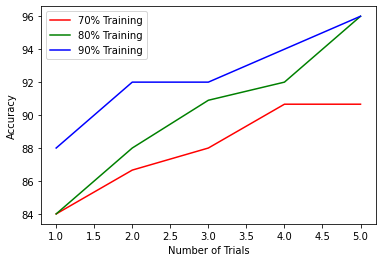

In [ ]:
# Trial runs of different training and testing splits
seventy = np.array([86.66, 84.00, 90.66, 90.66, 88.00])
eighty =  np.array([90.90, 96.00, 88.00, 84.00, 92.00])
ninety = np.array([94.00, 92.00, 92.00, 88.00, 96.00])

# Averages
avg_seventy = np.average(seventy)
avg_eighty = np.average(eighty)
avg_ninety = np.average(ninety)

print("70% training / 30% testing, Avg of 5: " + str(np.round(avg_seventy, 2)))
print("80% training / 20% testing, Avg of 5: " + str(np.round(avg_eighty, 2)))
print("90% training / 10% testing, Avg of 5: " + str(np.round(avg_ninety, 2)))

# Domain
x = np.array([1, 2, 3, 4, 5])

# X - Axis
plt.xlabel('Number of Trials')
# Y - Axis
plt.ylabel('Accuracy')

# Plotting
plt.plot(x, np.sort(seventy), 'r')
plt.plot(x, np.sort(eighty), 'g')
plt.plot(x, np.sort(ninety), 'b')

# Legend
plt.legend(['70% Training', '80% Training', '90% Training']) 